<a href="https://colab.research.google.com/github/lokeshkumarn/Notebooks/blob/master/FashionMnist_NetworkDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries/Dataset

### Import Libraries

In [ ]:
import time
import tensorflow as tf
from tensorflow.python.client import device_lib
from google.colab import drive

import pandas as pd
import numpy as np
import random as rd

from tensorflow import keras

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from matplotlib import pyplot as plt

In [ ]:
rd.seed(2020)         # Initialize the random number generator.
np.random.seed(2020)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(2020)  # sets the graph-level random seed

### Import Dataset

Load dataset from TF

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

### Check GPU

In [ ]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' ]

gpu_lst = get_available_gpus()

if(len(gpu_lst) > 0):
  print("GPU Enabled")
else:
  print("GPU Disabled")

GPU Enabled


## Data Visualization

Plot at least one sample from each class of the dataset 

In [ ]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

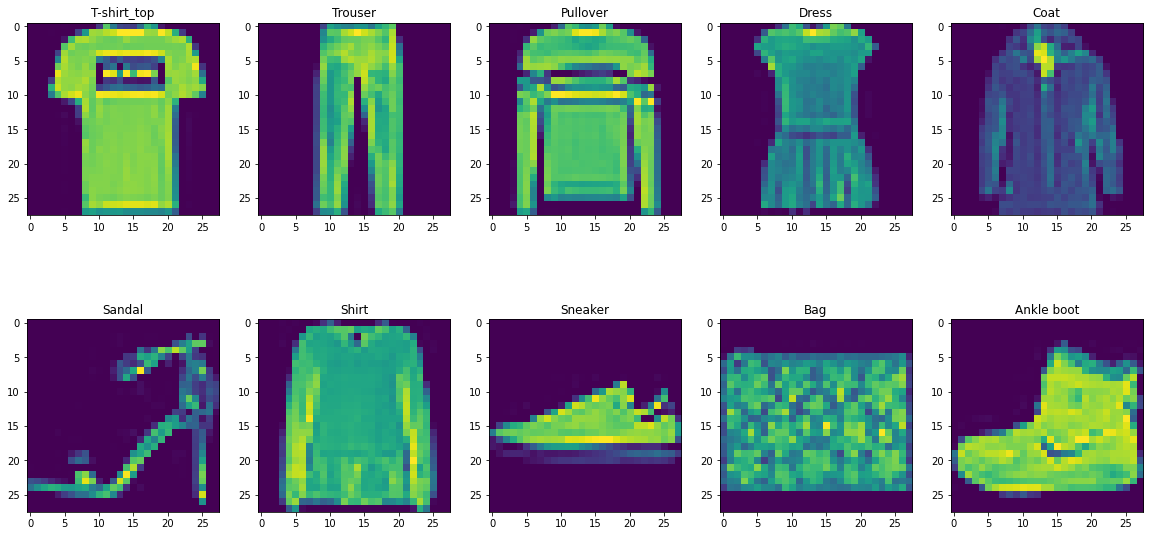

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(20,10))
j = 0
for c in enumerate(class_names):
  idx = [i for i,v in enumerate(y_train) if c[0] == v][0]
  row,col = j, c[0] % 5  
  ax[row,col].imshow(X_train[idx])
  ax[row,col].set_title(c[1])
  if c[0] % 5 == 4:
    j = j + 1

Print the shapes of train and test data

In [ ]:
print("Train Feature Shape:",X_train.shape)
print("Train Label Shape:",y_train.shape)
print("Test Feature Shape:",X_test.shape)
print("Test Label Shape:",y_test.shape)

Train Feature Shape: (60000, 28, 28)
Train Label Shape: (60000,)
Test Feature Shape: (10000, 28, 28)
Test Label Shape: (10000,)


## Data Pre-processing 

Bring the train and test data in the required format

In [ ]:
# Normalize the data
X_train = X_train.reshape((60000, 28*28))    # reshape the input set to size 28*28. VEctor of length 784
X_train = X_train.astype('float32')/255      # normalize to grayscale; set datatype as float32

X_test = X_test.reshape((10000, 28*28))      # reshape the input set to size 28*28. 
X_test = X_test.astype('float32')/255        # normalize to grayscale; set datatype as float32

y_train_enc = tf.keras.utils.to_categorical(y_train)
y_test_enc = tf.keras.utils.to_categorical(y_test)

In [ ]:
#Shapes after reshaping & normalizing
print("Train Feature Shape:",X_train.shape)
print("Train Label Shape:",y_train.shape)
print("Test Feature Shape:",X_test.shape)
print("Test Label Shape:",y_test.shape)

Train Feature Shape: (60000, 784)
Train Label Shape: (60000,)
Test Feature Shape: (10000, 784)
Test Label Shape: (10000,)


## Model Building 

a.    Sequential Model layers- Use AT LEAST 3 dense layers with appropriate input for each. Choose the best number for hidden units and give reasons.<br>
b.   Add L2 regularization to all the layers.<br>
c.    Add one layer of dropout at the appropriate position and give reasons. <br>d.   Choose the appropriate activation function for all the layers.<br>
e.   Print the model summary


In [ ]:
model = keras.models.Sequential()

# Layer 1 = input layer
# specify the input size for in the first layer.

model.add(keras.layers.Dense(50, activation='relu', input_shape= (28*28,)))

# Layer 2 = hidden layer  with Regularizers
model.add(keras.layers.Dense(60, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01)) )

# Add dropout of 50% to layer 2
model.add(keras.layers.Dropout(0.5))

# Layer 3 = hidden layer 
model.add(keras.layers.Dense(30, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01)) )

# Layer 4 = output layer
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3060      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
Total params: 44,450
Trainable params: 44,450
Non-trainable params: 0
_________________________________________________________________


## Model Compilation 

a.Compile the model with the appropriate loss function. - **categorical_crossentropy** - multiclass classification<br>
b.Use an appropriate optimizer - **Adam**. Give reasons for the choice of learning rate and its value.<br>
c.Use **accuracy** as metric.

In [ ]:
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'] )

##Model Training 

In [ ]:
start_train = time.time()
history = model.fit(X_train,
                    y_train_enc,
                    epochs=50,
                    batch_size=1000,
                    validation_split=0.2,
                    verbose=1)
end_train = time.time()

Epoch 1/50
48/48 [==============================] - 1s 11ms/step - loss: 2.6889 - accuracy: 0.4297 - val_loss: 2.0184 - val_accuracy: 0.6855
Epoch 2/50
48/48 [==============================] - 0s 7ms/step - loss: 1.8784 - accuracy: 0.6842 - val_loss: 1.4786 - val_accuracy: 0.7703
Epoch 3/50
48/48 [==============================] - 0s 7ms/step - loss: 1.4656 - accuracy: 0.7636 - val_loss: 1.1883 - val_accuracy: 0.8068
Epoch 4/50
48/48 [==============================] - 0s 7ms/step - loss: 1.2307 - accuracy: 0.7919 - val_loss: 1.0306 - val_accuracy: 0.8176
Epoch 5/50
48/48 [==============================] - 0s 7ms/step - loss: 1.0935 - accuracy: 0.8053 - val_loss: 0.9303 - val_accuracy: 0.8308
Epoch 6/50
48/48 [==============================] - 0s 7ms/step - loss: 1.0000 - accuracy: 0.8190 - val_loss: 0.8590 - val_accuracy: 0.8391
Epoch 7/50
48/48 [==============================] - 0s 7ms/step - loss: 0.9338 - accuracy: 0.8237 - val_loss: 0.8127 - val_accuracy: 0.8416
Epoch 8/50
48/48 [=

Plot the loss and accuracy history graphs

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


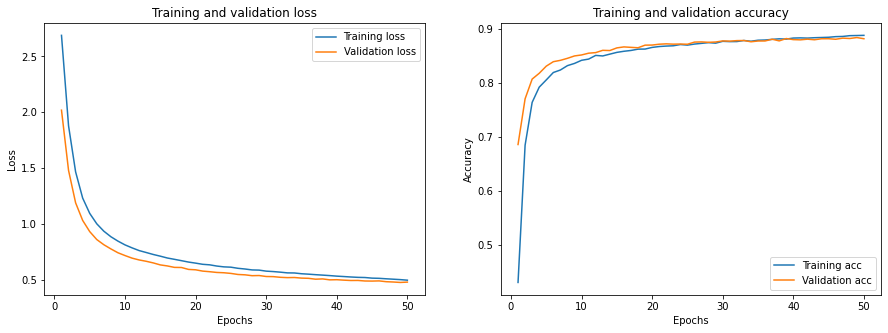

In [ ]:
fix,ax = plt.subplots(1,2, figsize=(15,5))
ax1 = ax[0] # to plot Training Loss
ax2 = ax[1] # to plot Training Accuracy
ax1.plot(epochs, loss, label='Training loss')
ax1.plot(epochs, val_loss,  label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, label='Training acc')
ax2.plot(epochs, val_acc,  label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
#Time taken to train
print("Time taken to train the NN:",end_train - start_train," seconds")

Time taken to train the NN: 18.979234218597412  seconds


## Model Evaluation 

Print the final test/validation loss and accuracy

In [ ]:
results = model.evaluate(X_test, y_test_enc)

print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.4986 - accuracy: 0.8759
Test Loss: 0.49857592582702637
Test Accuracy: 0.8758999705314636


In [ ]:
#Predictions
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Confusion Matrix

In [ ]:
df = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
df.head()
confusion_matrix = pd.crosstab(df['y_test'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    0    1    2    3    4    5    6    7    8    9
Actual                                                     
0          827    1    8   37    2    0  110    1   14    0
1            4  957    1   29    7    0    0    0    2    0
2           12    1  780   15  115    0   72    0    5    0
3           18    5    4  901   31    0   32    1    7    1
4            0    0   99   38  805    0   52    0    6    0
5            1    0    0    0    0  952    0   29    2   16
6          134    2   93   32   67    0  655    0   17    0
7            0    0    0    0    0   19    0  960    0   21
8            3    0    2    3    4    3    8    5  972    0
9            0    0    0    0    0    8    1   41    0  950


Classification Report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.99      0.96      0.97      1000
           2       0.79      0.78      0.79      1000
           3       0.85      0.90      0.88      1000
           4       0.78      0.81      0.79      1000
           5       0.97      0.95      0.96      1000
           6       0.70      0.66      0.68      1000
           7       0.93      0.96      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

